<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [16]</a>'.</span>

In [1]:
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode


print(f"pfp_api_client: {pfp_api_client.__version__}")

from pfp_api_client.pfp.estimator import Estimator, EstimatorMethodType
pfvm_estimator = Estimator(method_type=EstimatorMethodType.PFVM)
calculator = ASECalculator(pfvm_estimator)
def get_opt_energy(atoms, fmax=0.001, opt_mode: str = "normal"):    
    atoms.set_calculator(calculator)
    if opt_mode == "scale":
        opt1 = LBFGS(StrainFilter(atoms, mask=[1, 1, 1, 0, 0, 0]))
    elif opt_mode == "all":
        opt1 = LBFGS(ExpCellFilter(atoms))
    else:
        opt1 = LBFGS(atoms)
    opt1.run(fmax=fmax)
    return atoms.get_total_energy()

pfp_api_client: 1.8.0


In [2]:
from ase.cluster import Decahedron, Icosahedron, Octahedron, wulff_construction
from ase import Atoms 
from ase.io import Trajectory
import pandas as pd
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS
import numpy as np

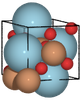

In [3]:
# bulk, support material
from ase.io.vasp import read_vasp
from ase import Atoms
from ase.build import fcc111, add_adsorbate, bulk
from ase.io import read, write
from PIL import Image
from IPython.display import display
lfo = read_vasp("CONTCAR")
def render_and_display_np(structure, index, max_size=(100, 100)):
    renderer = write('{index}.pov', structure, rotation='20z,-85x')
    renderer.render()
    image_path = '{index}.png'
    img = Image.open(image_path)
    img.thumbnail(max_size, Image.LANCZOS)
    display(img)
render_and_display_np(lfo,'./output/ini',(100, 100))


In [4]:
# Generate slab
from ase.build import make_supercell
import numpy as np
from pymatgen.core.surface import SlabGenerator
from pymatgen.io.ase import AseAtomsAdaptor
from ase.constraints import FixAtoms


slab_gen = SlabGenerator(
    initial_structure=AseAtomsAdaptor.get_structure(lfo),
    miller_index=[1,0,0],
    min_slab_size=50.0, # 
    min_vacuum_size=30.0, # nanoparticle
    lll_reduce=False,
    center_slab=True,
    primitive=True,
    max_normal_search=1,
)
slabs = slab_gen.get_slabs(tol=0.3, bonds=None, max_broken_bonds=0, symmetrize=False)


The resulting `slabs` are pymatgen instances. 
It can be converted to an ASE `Atoms` instance using `AseAtomsAdaptor`.

The obtained structure is converted to ASE `Atoms` and visualized.

In [5]:
slab_atoms_list = [AseAtomsAdaptor.get_atoms(slab) for slab in slabs]
slab=slab_atoms_list[1]

In [6]:
slab = slab_atoms_list[1].copy()

# make supercell: expand to xy-plane
#slab = make_supercell(slab, [[4, 0, 0], [0, 2, 0], [0, 0, 1]])  # this is same with below.
slab = slab * (4, 4, 1)

# shift `slab` to bottom of cell
min_pos_z = np.min(slab.positions, axis=0)[2]
slab.set_positions(slab.positions - [0, 0, min_pos_z])

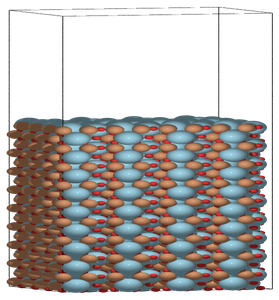

Atoms(symbols='Fe576La576O1728', pbc=True, cell=[[31.76, 0.0, 1.944739117045997e-15], [3.589329754078253e-15, 22.32, 1.3667058278484462e-15], [0.0, 0.0, 84.75]])

In [7]:
render_and_display_np(slab,'./output/ini',(300, 300))
slab

## replacing

In [8]:
len(slab)

2880

In [9]:
from ase.data import atomic_numbers
import numpy as np

numbers = slab.get_atomic_numbers()
fe_index=[]
for atom in slab: 
 if atom.symbol=='Fe':
    fe_index.append(atom.index)
print(len(fe_index))
replace_index=[]
replace_fe_index = np.random.choice(np.arange(len(fe_index)), size=70, replace=False)
for i in replace_fe_index:
    replace_index.append(fe_index[i])
print(f"Replace {replace_index} atom")
numbers[replace_index] = atomic_numbers['Pt']
slab.set_atomic_numbers(numbers)
slab

576
Replace [2741, 2182, 2480, 1902, 1701, 1340, 1381, 1961, 2183, 2101, 942, 1962, 680, 1000, 2502, 2221, 2241, 82, 2462, 1901, 2240, 2260, 2740, 0, 2723, 1301, 761, 2301, 1283, 182, 903, 2262, 220, 103, 1480, 1042, 802, 600, 320, 1783, 1201, 2402, 2722, 1262, 1642, 1541, 542, 2500, 623, 563, 2083, 300, 1963, 723, 2600, 2321, 581, 2303, 983, 963, 1122, 3, 202, 2842, 2122, 2683, 1723, 1363, 1463, 540] atom


Atoms(symbols='Fe506La576O1728Pt70', pbc=True, cell=[[31.76, 0.0, 1.944739117045997e-15], [3.589329754078253e-15, 22.32, 1.3667058278484462e-15], [0.0, 0.0, 84.75]])

In [10]:
from ase.constraints import FixAtoms
mask=slab.positions[:, 2] < 5.0
c = FixAtoms(mask=mask)
slab.set_constraint(c)
slab

Atoms(symbols='Fe506La576O1728Pt70', pbc=True, cell=[[31.76, 0.0, 1.944739117045997e-15], [3.589329754078253e-15, 22.32, 1.3667058278484462e-15], [0.0, 0.0, 84.75]], constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1

In [11]:
import copy

o_vac_surf = []
initial_atoms = slab.copy()

thresholds = [43,45,47,49,51]

for threshold in thresholds:
    atoms = initial_atoms.copy()
    
    # Find the indices of oxygen atoms with z > threshold
    indices_to_remove = [atom.index for atom in atoms if atom.symbol == 'O' and atom.position[2] > threshold]

    # Delete the atoms with the specified indices
    del atoms[indices_to_remove]

    # Calculate the percentage of oxygen atoms deleted
    o_removed = len([atom for atom in initial_atoms if atom.symbol == 'O' and atom.position[2] > threshold])
    total_o = len([atom for atom in initial_atoms if atom.symbol == 'O'])
    percentage_removed = round(o_removed / total_o * 100, 3)

    print(f"Threshold: {threshold} Å, O atoms removed: {o_removed}, total O atoms: {total_o}, percentage removed: {percentage_removed}%")
    
    # Append the modified structure to the list
    o_vac_surf.append(atoms)
import matplotlib.pyplot as plt
from ase.visualize import view

def render_and_save_np(structure, index, max_size=(100, 100)):
    renderer = write(f'{index}.pov', structure, rotation='20z,-85x')
    renderer.render()
    image_path = f'{index}.png'
    img = Image.open(image_path)
    img.thumbnail(max_size, Image.LANCZOS)
    return img
'''
# Prepare the figures and axes for subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Render and display each structure
for i, structure in enumerate(o_vac_surf):
    img = render_and_save_np(structure, i)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Structure {i + 1}")
'''


Threshold: 43 Å, O atoms removed: 224, total O atoms: 1728, percentage removed: 12.963%
Threshold: 45 Å, O atoms removed: 192, total O atoms: 1728, percentage removed: 11.111%
Threshold: 47 Å, O atoms removed: 96, total O atoms: 1728, percentage removed: 5.556%
Threshold: 49 Å, O atoms removed: 32, total O atoms: 1728, percentage removed: 1.852%
Threshold: 51 Å, O atoms removed: 0, total O atoms: 1728, percentage removed: 0.0%


'\n# Prepare the figures and axes for subplots\nfig, axes = plt.subplots(1, 5, figsize=(15, 3))\n\n# Render and display each structure\nfor i, structure in enumerate(o_vac_surf):\n    img = render_and_save_np(structure, i)\n    axes[i].imshow(img)\n    axes[i].axis(\'off\')\n    axes[i].set_title(f"Structure {i + 1}")\n'

# MD simulation

In [12]:
!pip install tqdm


Looking in indexes: https://pypi.matlantis-common.svc:8080/simple


You should consider upgrading via the '/home/jovyan/.local/bin/python -m pip install --upgrade pip' command.


In [13]:
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
pfvm_estimator = Estimator(method_type=EstimatorMethodType.PFVM)
calculator = ASECalculator(pfvm_estimator)

import ase
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase.md import MDLogger
from ase import units
from time import perf_counter

import time

def run_md_calculation(structure, structure_index, temperature):
    # Set up a crystal
    atoms = structure
    atoms.pbc = True
    atoms.calc = calculator

    # Input parameters
    time_step = 1.0  # fsec
    num_md_steps = 10000  # Total MD step, for testing.
    num_interval = 200  # Output printing interval
    friction_coeff = 0.002

    # Define output filenames
    output_filename = f"./output/structure_{structure_index}_{temperature}K_10ps"
    log_filename = output_filename + ".log"
    traj_filename = output_filename + ".traj"

    # Run MD
    dyn = Langevin(atoms, time_step*units.fs, friction=friction_coeff, temperature_K=temperature, loginterval=num_interval, trajectory=traj_filename)

    # Print statements
    def print_dyn():
        imd = dyn.get_number_of_steps()
        etot  = atoms.get_total_energy()
        temp_K = atoms.get_temperature()
        stress = atoms.get_stress(include_ideal_gas=True)/units.GPa
        stress_ave = (stress[0]+stress[1]+stress[2])/3.0 
        elapsed_time = perf_counter() - start_time
        print(f"{imd: >3}   {etot:.3f}    {temp_K:.2f}    {stress_ave:.2f}  {stress[0]:.2f}  {stress[1]:.2f}  {stress[2]:.2f}  {stress[3]:.2f}  {stress[4]:.2f}  {stress[5]:.2f}    {elapsed_time:.3f}")

    dyn.attach(print_dyn, interval=num_interval)
    dyn.attach(MDLogger(dyn, atoms, log_filename, header=True, stress=True, peratom=True, mode="w"), interval=num_interval)

    # Now run the dynamics
    print(f"Structure {structure_index + 1}, Temperature {temperature}K:")
    print(f"    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)")
    start_time = perf_counter()
    dyn.run(num_md_steps)
    simulation_time = perf_counter() - start_time
    print(f"Total simulation time for structure {structure_index + 1} at {temperature}K: {simulation_time:.3f} seconds")

temperatures = [600, 800]

for temp in temperatures:
    print(f"Running MD calculations at {temp}K...")
    for i, structure in enumerate(o_vac_surf):
        print(f"Running MD calculation for structure {i + 1} at {temp}K...")
        run_md_calculation(structure, i, temp)
        print(f"Finished MD calculation for structure {i + 1} at {temp}K\n")
    print(f"Finished MD calculations at {temp}K\n")


Running MD calculations at 600K...
Running MD calculation for structure 1 at 600K...
Structure 1, Temperature 600K:
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)


  0   -15481.896    0.00    2.43  2.58  2.29  2.43  0.00  0.00  -0.01    0.597


200   -15471.539    163.42    1.70  1.73  2.01  1.35  -0.01  0.01  -0.02    218.955


400   -15462.154    210.66    1.91  2.04  1.86  1.82  -0.20  0.04  -0.01    438.179


600   -15453.916    238.23    1.72  1.98  1.74  1.45  -0.14  0.02  0.03    652.466


800   -15446.245    273.19    1.74  2.02  1.55  1.66  -0.15  0.01  0.02    872.697


1000   -15439.394    283.89    1.62  1.88  1.59  1.39  -0.08  0.01  0.00    1096.654


1200   -15432.679    291.48    1.69  1.86  1.59  1.61  -0.06  0.01  0.05    1312.882


1400   -15426.613    324.21    1.49  1.66  1.46  1.37  -0.03  0.04  0.01    1524.950


1600   -15419.328    337.65    1.49  1.68  1.44  1.34  -0.11  -0.03  0.02    1734.330


1800   -15414.081    351.42    1.38  1.44  1.28  1.41  -0.06  -0.01  0.05    1946.105


2000   -15408.836    364.87    1.24  1.41  1.14  1.18  -0.05  -0.06  0.04    2154.357


2200   -15405.931    386.14    1.23  1.39  1.14  1.15  -0.04  -0.08  0.03    2382.028


2400   -15401.133    403.04    1.07  1.21  1.10  0.92  -0.14  -0.01  0.03    2599.526


2600   -15397.048    418.79    1.23  1.36  1.13  1.21  -0.08  0.03  -0.01    2807.234


2800   -15393.342    423.62    1.01  1.15  0.97  0.90  -0.06  -0.08  0.01    3023.683


3000   -15387.688    453.00    1.16  1.31  1.09  1.07  -0.15  -0.00  0.00    3237.565


3200   -15385.522    453.59    0.99  1.16  0.87  0.94  -0.10  0.03  -0.06    3473.909


3400   -15381.871    456.79    0.94  1.09  0.90  0.82  -0.06  -0.12  -0.04    3701.542


3600   -15378.214    474.45    0.93  1.07  0.94  0.79  -0.13  -0.12  -0.09    3925.343


3800   -15376.329    487.25    0.82  1.03  0.81  0.63  -0.02  -0.11  -0.11    4146.365


4000   -15373.086    490.61    0.88  1.06  0.82  0.75  -0.04  -0.06  -0.00    4367.774


4200   -15369.697    505.00    0.81  1.03  0.71  0.68  -0.06  -0.12  0.02    4585.874


4400   -15368.146    515.97    0.79  0.97  0.76  0.62  -0.10  -0.06  -0.02    4796.485


4600   -15367.326    525.81    0.84  1.06  0.68  0.76  -0.01  -0.12  0.00    5013.759


4800   -15364.504    532.14    0.78  0.97  0.76  0.62  -0.10  -0.15  0.00    5233.409


5000   -15364.182    546.39    0.58  0.81  0.55  0.39  -0.08  -0.08  -0.08    5459.272


5200   -15364.161    545.76    0.57  0.63  0.56  0.52  -0.04  -0.16  -0.05    5660.734


5400   -15362.427    561.69    0.70  0.88  0.68  0.52  0.05  -0.10  0.01    5872.855


5600   -15361.493    548.62    0.48  0.67  0.41  0.36  -0.09  -0.15  0.06    6090.127


5800   -15361.762    565.32    0.55  0.67  0.52  0.45  0.02  -0.20  0.03    6312.854


6000   -15360.575    567.27    0.59  0.81  0.47  0.49  -0.03  -0.08  0.07    6537.398


6200   -15361.510    568.82    0.55  0.73  0.45  0.46  -0.05  -0.16  -0.03    6753.313


6400   -15361.204    571.84    0.56  0.71  0.59  0.38  -0.06  -0.14  -0.10    6976.601


6600   -15360.287    583.11    0.50  0.63  0.48  0.40  -0.06  -0.12  0.02    7195.594


6800   -15361.059    583.07    0.47  0.62  0.42  0.36  -0.06  -0.12  -0.06    7411.937


7000   -15361.617    595.01    0.50  0.68  0.42  0.41  0.01  -0.15  0.03    7628.769


7200   -15360.491    594.23    0.43  0.66  0.33  0.29  0.04  -0.17  -0.04    7847.057


7400   -15359.884    599.02    0.44  0.61  0.29  0.40  -0.08  -0.08  -0.00    8072.396


7600   -15359.113    606.21    0.54  0.72  0.45  0.44  -0.02  -0.02  -0.05    8298.614


7800   -15359.014    608.61    0.57  0.70  0.52  0.48  0.01  -0.11  -0.07    8517.935


8000   -15358.605    612.35    0.41  0.55  0.39  0.29  -0.00  -0.11  0.02    8736.426


8200   -15360.548    599.84    0.36  0.47  0.29  0.32  -0.04  -0.11  -0.05    8952.729


8400   -15360.987    615.27    0.42  0.60  0.35  0.31  -0.07  -0.08  -0.03    9167.574


8600   -15361.682    597.07    0.38  0.57  0.30  0.29  -0.04  -0.08  -0.06    9375.320


8800   -15359.933    605.10    0.32  0.51  0.26  0.19  -0.10  -0.11  0.03    9587.920


9000   -15360.622    620.89    0.35  0.40  0.27  0.37  0.02  -0.10  0.01    9807.734


9200   -15360.358    612.37    0.33  0.52  0.21  0.26  -0.01  -0.18  0.04    10025.010


9400   -15362.255    607.14    0.42  0.64  0.25  0.38  -0.05  -0.15  0.08    10238.847


9600   -15361.720    612.22    0.38  0.51  0.37  0.27  0.02  -0.03  0.05    10454.094


9800   -15363.580    623.89    0.43  0.55  0.37  0.38  0.01  -0.09  0.02    10664.539


10000   -15363.953    625.42    0.38  0.52  0.35  0.27  0.01  -0.08  0.01    10881.857
Total simulation time for structure 1 at 600K: 10881.859 seconds
Finished MD calculation for structure 1 at 600K

Running MD calculation for structure 2 at 600K...
Structure 2, Temperature 600K:
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)


  0   -15707.798    0.00    2.33  2.48  2.16  2.35  -0.01  0.00  -0.01    1.135


200   -15696.900    151.35    1.70  1.59  2.15  1.36  -0.01  0.01  0.00    221.670


400   -15686.929    209.24    1.84  1.85  1.78  1.90  -0.10  0.01  0.01    438.524


600   -15676.531    241.61    1.68  1.91  1.72  1.43  -0.04  0.01  -0.01    661.425


800   -15668.378    260.31    1.70  1.91  1.70  1.49  -0.01  0.04  0.02    875.066


1000   -15660.936    291.73    1.70  1.85  1.66  1.58  -0.06  0.05  0.04    1104.269


1200   -15653.111    307.73    1.58  1.77  1.51  1.46  0.00  -0.02  -0.02    1321.891


1400   -15647.643    323.42    1.57  1.79  1.46  1.46  -0.03  0.01  -0.01    1544.034


1600   -15641.451    336.15    1.47  1.62  1.49  1.30  -0.06  0.03  -0.03    1766.726


1800   -15636.306    356.51    1.47  1.57  1.43  1.41  -0.05  0.02  0.04    1987.151


2000   -15631.280    377.20    1.23  1.40  1.22  1.08  -0.01  0.05  0.02    2199.945


2200   -15625.391    403.04    1.23  1.36  1.15  1.19  0.05  0.10  0.01    2418.949


2400   -15621.356    413.41    1.23  1.44  1.14  1.10  -0.01  0.13  -0.00    2643.474


2600   -15617.162    430.61    1.19  1.29  1.21  1.07  0.03  0.05  0.01    2867.252


2800   -15613.278    446.97    1.09  1.18  1.13  0.96  -0.01  0.04  0.03    3089.002


3000   -15609.211    457.87    1.15  1.33  1.12  0.99  0.02  0.01  0.06    3304.296


3200   -15603.767    473.96    1.07  1.21  1.02  0.97  -0.01  0.06  -0.01    3475.608


3400   -15599.069    476.80    0.98  1.03  0.99  0.91  -0.01  -0.00  0.01    3607.644


3600   -15595.920    489.54    0.95  1.06  0.88  0.92  -0.04  0.04  -0.05    3717.473


3800   -15592.607    507.97    0.89  0.99  0.92  0.75  -0.01  0.05  0.03    3825.478


4000   -15589.178    512.13    0.98  1.02  0.92  0.99  -0.09  0.09  0.01    3931.292


4200   -15586.615    530.45    0.75  0.85  0.71  0.70  -0.09  0.07  -0.01    4044.026


4400   -15583.151    545.29    0.73  0.81  0.61  0.78  -0.04  0.17  0.02    4162.651


4600   -15581.198    538.68    0.78  0.85  0.76  0.74  -0.03  0.11  0.00    4286.132


4800   -15579.556    552.34    0.66  0.78  0.56  0.63  0.04  0.08  -0.01    4411.320


5000   -15579.369    542.12    0.67  0.86  0.45  0.69  0.06  0.18  -0.01    4530.422


5200   -15577.612    564.55    0.78  0.86  0.71  0.77  -0.07  0.06  -0.04    4640.842


5400   -15578.234    554.51    0.73  0.92  0.57  0.71  -0.02  0.06  -0.03    4754.499


5600   -15578.106    577.22    0.72  0.84  0.69  0.63  -0.00  0.07  -0.03    4867.979


5800   -15579.006    565.41    0.57  0.71  0.50  0.49  0.05  0.10  -0.04    4980.979


6000   -15577.071    578.55    0.75  0.80  0.78  0.67  0.02  0.08  0.04    5093.523


6200   -15575.973    564.55    0.67  0.73  0.64  0.63  0.04  0.06  0.05    5208.101


6400   -15577.389    582.53    0.60  0.70  0.44  0.66  -0.07  0.10  0.01    5323.502


6600   -15575.194    592.34    0.59  0.71  0.54  0.53  -0.11  0.01  -0.05    5436.217


6800   -15573.995    571.74    0.57  0.64  0.41  0.66  -0.10  0.10  -0.02    5549.804


7000   -15573.683    583.26    0.45  0.56  0.41  0.39  -0.09  0.15  -0.04    5666.846


7200   -15571.252    597.09    0.65  0.71  0.64  0.60  -0.03  0.03  0.02    5779.878


7400   -15572.799    602.73    0.48  0.63  0.28  0.52  -0.05  0.05  0.01    5899.506


7600   -15573.051    595.58    0.53  0.63  0.51  0.45  -0.03  0.16  0.01    6021.298


7800   -15573.147    608.47    0.62  0.69  0.53  0.64  0.04  0.18  0.01    6146.868


8000   -15574.920    613.57    0.46  0.51  0.44  0.43  -0.02  0.17  0.02    6267.743


8200   -15576.405    589.91    0.54  0.57  0.50  0.55  -0.07  0.13  -0.07    6387.612


8400   -15575.503    590.68    0.54  0.64  0.46  0.53  -0.08  0.17  0.06    6506.099


8600   -15575.465    606.39    0.56  0.66  0.57  0.45  -0.08  0.11  -0.06    6629.456


8800   -15575.492    612.26    0.46  0.57  0.37  0.43  -0.09  0.16  0.03    6750.369


9000   -15578.204    601.00    0.47  0.52  0.45  0.42  -0.07  0.16  -0.06    6865.994


9200   -15579.637    607.56    0.52  0.54  0.46  0.55  -0.02  0.17  -0.05    6985.328


9400   -15581.034    598.93    0.46  0.70  0.31  0.37  -0.05  0.13  -0.12    7111.139


9600   -15579.937    601.62    0.50  0.59  0.48  0.44  -0.16  0.13  -0.02    7237.146


9800   -15578.370    604.68    0.51  0.55  0.42  0.55  -0.19  0.19  0.01    7362.055


10000   -15578.771    605.78    0.33  0.38  0.27  0.34  -0.10  0.16  -0.08    7483.551
Total simulation time for structure 2 at 600K: 7483.553 seconds
Finished MD calculation for structure 2 at 600K

Running MD calculation for structure 3 at 600K...
Structure 3, Temperature 600K:
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)


  0   -16398.006    0.00    2.06  2.18  1.88  2.12  -0.01  0.00  -0.01    1.139


200   -16385.372    136.76    2.14  2.33  2.30  1.81  -0.09  0.03  0.01    145.379


400   -16375.012    175.93    1.77  1.84  1.70  1.77  -0.03  0.03  0.03    285.930


600   -16364.781    197.98    1.62  1.83  1.70  1.34  -0.02  0.02  0.01    421.100


800   -16355.730    214.74    1.69  1.79  1.65  1.63  -0.01  0.01  -0.03    557.699


1000   -16347.345    243.65    1.56  1.69  1.56  1.43  0.02  0.04  -0.01    695.118


1200   -16339.102    259.08    1.73  1.87  1.67  1.65  -0.03  0.06  0.00    825.383


1400   -16329.545    274.20    1.62  1.70  1.60  1.57  0.06  0.07  -0.02    958.351


1600   -16322.581    302.40    1.58  1.66  1.57  1.51  0.02  -0.04  -0.02    1088.629


1800   -16313.954    318.28    1.52  1.60  1.47  1.48  0.01  -0.04  0.02    1219.204


2000   -16307.009    342.78    1.26  1.38  1.31  1.10  0.00  0.04  -0.04    1349.351


2200   -16300.135    350.35    1.31  1.40  1.29  1.26  0.04  -0.01  -0.01    1484.888


2400   -16294.395    375.54    1.20  1.37  1.11  1.12  -0.02  -0.00  0.03    1622.448


2600   -16288.666    377.84    1.17  1.31  1.09  1.12  0.01  -0.02  -0.04    1754.226


2800   -16283.080    409.89    1.20  1.28  1.16  1.17  -0.08  -0.01  0.04    1883.016


3000   -16278.916    396.48    1.16  1.25  1.09  1.15  -0.04  0.05  0.00    2011.628


3200   -16275.070    419.17    1.27  1.36  1.15  1.30  -0.07  -0.02  -0.06    2139.365


3400   -16269.740    417.86    1.00  1.09  0.94  0.97  -0.00  0.01  0.03    2271.022


3600   -16265.164    431.86    1.12  1.25  0.99  1.12  -0.01  -0.08  -0.01    2401.479


3800   -16261.057    450.66    0.98  1.11  0.90  0.93  0.01  -0.06  0.04    2530.814


4000   -16257.139    462.65    1.00  1.07  0.86  1.06  0.00  -0.02  -0.01    2663.292


4200   -16253.413    463.84    0.91  1.07  0.76  0.90  0.03  -0.03  -0.01    2799.080


4400   -16252.510    474.21    1.00  1.15  0.93  0.91  0.02  -0.03  0.06    2931.039


4600   -16249.694    465.87    0.98  1.02  0.93  1.00  0.08  0.02  0.08    3060.622


4800   -16246.654    483.28    1.03  1.05  0.92  1.12  -0.05  0.02  -0.08    3187.416


5000   -16243.044    483.61    0.97  1.09  0.85  0.96  -0.05  -0.05  0.07    3313.665


5200   -16239.497    509.26    0.87  1.00  0.80  0.82  -0.00  -0.10  -0.00    3451.184


5400   -16236.220    502.10    0.85  0.98  0.70  0.86  -0.07  -0.06  -0.01    3581.283


5600   -16233.758    515.51    0.78  0.83  0.65  0.85  -0.03  -0.07  0.04    3710.346


5800   -16230.763    526.18    0.71  0.85  0.56  0.72  -0.03  -0.11  0.04    3837.366


6000   -16230.804    530.69    0.81  0.90  0.64  0.91  -0.04  -0.12  0.02    3966.494


6200   -16228.055    537.14    0.70  0.76  0.64  0.70  -0.01  -0.03  0.02    4101.792


6400   -16226.260    540.14    0.73  0.89  0.60  0.71  -0.02  -0.02  0.05    4224.351


6600   -16223.680    535.42    0.77  0.86  0.64  0.80  -0.04  0.06  -0.03    4345.314


6800   -16220.487    546.11    0.85  0.94  0.67  0.93  0.01  -0.04  -0.01    4469.545


7000   -16221.726    557.09    0.76  0.84  0.65  0.78  0.04  0.00  0.06    4599.453


7200   -16219.912    552.05    0.69  0.70  0.65  0.72  0.03  -0.08  0.04    4731.182


7400   -16219.431    543.79    0.66  0.73  0.55  0.68  -0.07  -0.05  0.06    4868.182


7600   -16219.504    536.11    0.69  0.74  0.57  0.75  -0.03  -0.10  0.09    4994.632


7800   -16215.106    559.26    0.58  0.59  0.56  0.58  -0.04  -0.03  0.01    5124.589


8000   -16213.040    558.61    0.62  0.73  0.58  0.56  -0.01  -0.03  0.01    5254.432


8200   -16210.976    567.44    0.80  0.80  0.75  0.84  -0.01  0.02  0.03    5380.667


8400   -16210.711    563.52    0.67  0.64  0.58  0.78  0.01  0.02  -0.01    5509.736


8600   -16208.468    567.13    0.71  0.69  0.65  0.79  0.00  -0.03  0.07    5636.401


8800   -16209.206    573.65    0.69  0.73  0.61  0.73  -0.05  -0.05  0.03    5769.160


9000   -16205.995    579.95    0.60  0.73  0.37  0.70  -0.05  -0.03  -0.00    5898.110


9200   -16207.323    565.41    0.57  0.73  0.43  0.54  -0.09  0.05  0.07    6030.951


9400   -16206.131    559.41    0.46  0.59  0.33  0.45  -0.05  -0.06  0.04    6159.190


9600   -16206.048    567.42    0.52  0.59  0.35  0.64  -0.06  0.02  -0.04    6291.152


9800   -16204.546    583.18    0.60  0.61  0.49  0.70  0.03  -0.01  0.08    6422.677


10000   -16202.359    587.19    0.68  0.76  0.52  0.76  0.08  -0.06  0.03    6556.134
Total simulation time for structure 3 at 600K: 6556.145 seconds
Finished MD calculation for structure 3 at 600K

Running MD calculation for structure 4 at 600K...
Structure 4, Temperature 600K:
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)


  0   -16862.671    0.00    1.95  2.05  1.78  2.02  0.02  0.00  -0.00    0.576


200   -16849.301    150.63    1.80  1.88  1.70  1.83  -0.26  0.03  0.02    140.752


400   -16837.662    202.15    1.78  2.05  1.44  1.86  -0.05  -0.00  0.05    282.523


600   -16825.994    204.33    1.56  1.87  1.44  1.36  -0.13  0.02  0.01    423.317


800   -16815.626    234.05    1.61  1.85  1.33  1.65  -0.06  -0.02  -0.02    563.621


1000   -16805.250    258.24    1.67  1.93  1.51  1.57  -0.03  -0.03  -0.00    702.151


1200   -16796.246    259.83    1.69  1.89  1.50  1.69  0.01  -0.02  0.02    835.158


1400   -16787.639    273.77    1.70  1.96  1.45  1.68  -0.03  -0.05  -0.00    960.666


1600   -16778.968    292.96    1.61  1.83  1.43  1.56  -0.04  -0.02  0.02    1089.892


1800   -16772.670    301.26    1.45  1.66  1.25  1.45  -0.00  0.09  0.01    1231.899


2000   -16766.468    316.40    1.37  1.56  1.25  1.29  -0.01  0.07  -0.04    1371.589


2200   -16758.619    325.36    1.38  1.56  1.14  1.43  0.03  0.04  -0.05    1519.173


2400   -16752.529    346.06    1.29  1.46  1.14  1.26  -0.02  0.02  0.02    1656.426


2600   -16746.014    352.37    1.38  1.51  1.16  1.47  -0.03  0.02  -0.00    1798.019


2800   -16738.641    358.17    1.27  1.44  1.11  1.28  -0.06  -0.05  -0.00    1935.806


3000   -16731.460    376.82    1.34  1.49  1.13  1.40  -0.10  -0.04  0.02    2078.846


3200   -16726.611    380.28    1.26  1.42  1.03  1.34  -0.05  -0.02  0.06    2228.416


3400   -16721.134    389.65    1.19  1.38  1.00  1.20  -0.08  -0.02  -0.03    2366.442


3600   -16715.300    397.86    1.26  1.41  1.09  1.27  -0.09  -0.01  -0.06    2503.368


3800   -16710.790    417.44    1.10  1.19  0.89  1.20  -0.06  0.00  -0.03    2644.884


4000   -16704.561    411.33    1.09  1.25  0.92  1.11  -0.01  0.07  0.04    2782.623


4200   -16700.205    409.52    1.12  1.27  0.96  1.13  -0.05  0.07  -0.02    2915.745


4400   -16698.567    424.39    1.19  1.31  1.01  1.25  -0.09  0.06  -0.01    3052.952


4600   -16694.169    416.40    1.06  1.18  0.90  1.10  -0.02  0.09  -0.00    3190.143


4800   -16689.066    447.11    0.97  1.07  0.78  1.08  -0.03  -0.01  0.00    3332.440


5000   -16685.299    443.13    1.05  1.17  0.89  1.09  0.01  0.03  0.01    3469.565


5200   -16680.587    444.90    1.04  1.15  0.82  1.15  -0.01  0.01  -0.01    3612.429


5400   -16674.652    470.88    0.93  1.03  0.74  1.01  -0.10  0.00  0.08    3751.020


5600   -16669.935    470.90    1.08  1.20  0.82  1.24  -0.08  0.04  -0.01    3891.678


5800   -16666.551    474.05    0.81  0.92  0.66  0.85  -0.05  0.03  -0.04    4032.259


6000   -16664.502    481.32    1.01  1.07  0.85  1.11  -0.01  0.07  -0.00    4177.088


6200   -16662.739    487.14    0.91  1.03  0.75  0.97  -0.04  0.06  0.08    4323.866


6400   -16658.862    482.96    0.93  1.00  0.73  1.08  -0.04  0.05  0.04    4465.804


6600   -16656.308    498.15    1.00  1.13  0.73  1.13  -0.02  0.04  -0.01    4600.075


6800   -16652.530    498.48    0.89  1.03  0.72  0.93  0.02  0.07  -0.01    4736.954


7000   -16650.019    498.13    0.97  1.09  0.74  1.09  -0.04  0.08  -0.02    4875.366


7200   -16646.508    508.57    0.80  0.87  0.69  0.83  -0.04  0.03  0.00    5020.253


7400   -16641.524    521.96    0.90  1.03  0.61  1.06  -0.15  0.04  0.05    5162.837


7600   -16638.591    517.55    0.81  0.96  0.61  0.87  -0.08  0.02  0.01    5296.363


7800   -16632.625    532.62    0.81  0.95  0.56  0.92  -0.10  0.01  0.02    5432.669


8000   -16628.652    534.43    0.83  0.90  0.63  0.95  -0.02  0.03  0.02    5571.795


8200   -16627.893    537.76    0.82  0.91  0.64  0.92  -0.09  0.03  0.03    5712.068


8400   -16625.768    536.66    0.82  0.92  0.60  0.94  0.03  0.02  -0.05    5851.966


8600   -16624.073    530.89    0.79  0.82  0.62  0.94  -0.01  0.05  0.02    5986.826


8800   -16623.504    542.97    0.80  0.87  0.55  0.99  -0.01  0.04  -0.00    6128.075


9000   -16621.015    532.34    0.77  0.85  0.60  0.87  -0.02  0.02  -0.03    6255.844


9200   -16619.159    548.60    0.76  0.89  0.54  0.85  -0.06  0.02  0.02    6380.823


9400   -16618.896    551.30    0.89  0.94  0.68  1.03  -0.02  0.07  0.06    6506.375


9600   -16616.570    548.75    0.77  0.83  0.59  0.88  -0.04  0.00  0.03    6648.222


9800   -16615.511    563.67    0.75  0.84  0.55  0.86  -0.07  0.05  0.03    6783.908


10000   -16614.323    558.58    0.78  0.77  0.61  0.97  -0.05  0.00  0.04    6921.558
Total simulation time for structure 4 at 600K: 6921.565 seconds
Finished MD calculation for structure 4 at 600K

Running MD calculation for structure 5 at 600K...
Structure 5, Temperature 600K:
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)


  0   -17099.931    0.00    1.93  2.10  1.74  1.94  0.02  0.00  -0.01    0.581


200   -17085.355    128.14    2.11  2.40  2.14  1.78  -0.02  0.02  0.01    141.373


400   -17073.203    148.27    1.95  2.00  1.82  2.04  -0.03  0.03  0.02    289.584


600   -17063.075    161.86    1.73  1.85  1.86  1.48  -0.01  0.00  0.00    431.787


800   -17051.672    182.53    1.78  1.92  1.76  1.68  0.01  0.00  0.03    576.268


1000   -17041.718    199.98    1.74  1.80  1.77  1.65  -0.05  0.01  -0.02    718.203


1200   -17031.783    210.18    1.72  1.79  1.67  1.71  -0.03  0.04  0.01    849.137


1400   -17021.845    229.18    1.84  1.92  1.79  1.81  0.01  0.05  0.00    969.184


1600   -17014.083    239.86    1.77  1.80  1.81  1.70  -0.02  0.01  -0.01    1092.407


1800   -17004.661    257.46    1.65  1.74  1.59  1.62  0.03  -0.03  0.03    1232.373


2000   -16996.287    272.47    1.59  1.69  1.57  1.51  -0.04  -0.04  0.02    1359.531


2200   -16988.914    284.29    1.51  1.61  1.49  1.41  0.01  -0.02  -0.00    1481.441


2400   -16979.843    290.85    1.44  1.57  1.40  1.35  0.00  -0.02  0.03    1601.913


2600   -16972.226    310.97    1.48  1.57  1.40  1.48  -0.03  -0.00  0.02    1740.441


2800   -16964.319    317.83    1.57  1.64  1.49  1.58  -0.00  0.05  -0.02    1881.626


3000   -16956.605    329.85    1.51  1.51  1.52  1.49  -0.01  0.01  -0.02    2025.029


3200   -16951.599    348.95    1.56  1.59  1.46  1.63  -0.06  0.03  -0.00    2167.651


3400   -16944.809    354.58    1.39  1.49  1.37  1.31  -0.04  0.00  0.02    2310.787


3600   -16937.758    359.04    1.23  1.31  1.26  1.13  -0.08  0.02  -0.00    2453.216


3800   -16933.370    363.03    1.33  1.41  1.31  1.28  -0.00  0.05  0.02    2594.306


4000   -16926.564    373.84    1.19  1.27  1.20  1.10  -0.03  -0.00  -0.00    2739.740


4200   -16920.131    380.09    1.35  1.34  1.30  1.41  0.01  -0.00  0.01    2881.851


4400   -16915.417    395.06    1.30  1.36  1.31  1.24  -0.03  0.01  0.04    3022.899


4600   -16909.170    398.92    1.31  1.34  1.18  1.40  0.01  -0.01  -0.02    3166.876


4800   -16903.834    410.09    1.28  1.30  1.23  1.30  -0.08  -0.00  0.01    3312.694


5000   -16899.537    419.42    1.16  1.21  1.12  1.16  -0.01  -0.00  0.01    3457.309


5200   -16894.546    426.70    1.10  1.14  1.08  1.07  -0.06  0.03  -0.00    3581.334


5400   -16888.222    426.90    1.07  1.08  1.06  1.07  -0.03  -0.01  0.04    3696.265


5600   -16884.874    438.94    1.17  1.23  1.12  1.17  -0.07  0.11  -0.01    3811.385


5800   -16882.492    430.44    1.13  1.15  1.07  1.18  0.02  0.03  0.02    3928.327


6000   -16878.682    450.96    1.22  1.26  1.13  1.27  0.02  -0.01  0.01    4047.183


6200   -16876.308    449.69    1.21  1.27  1.15  1.22  -0.01  -0.08  0.05    4166.415


6400   -16873.483    450.09    1.17  1.24  1.10  1.17  0.01  -0.07  -0.06    4284.913


6600   -16868.890    467.66    1.01  1.03  1.00  1.01  0.02  -0.03  0.01    4403.767


6800   -16865.660    469.80    1.02  1.02  0.94  1.09  0.04  0.06  0.06    4523.056


7000   -16859.968    467.26    0.98  1.01  0.96  0.98  0.03  0.03  -0.03    4642.573


7200   -16855.952    484.25    1.05  1.07  1.02  1.06  0.00  0.07  0.02    4761.375


7400   -16851.074    484.06    1.13  1.12  1.01  1.26  -0.03  0.02  -0.01    4879.782


7600   -16846.625    516.16    1.10  1.14  0.95  1.21  -0.01  0.04  -0.06    4998.335


7800   -16843.152    497.59    1.03  1.03  0.95  1.11  -0.04  0.03  -0.07    5115.188


8000   -16839.451    504.59    0.99  1.01  0.93  1.02  -0.04  -0.03  0.04    5228.172


8200   -16836.220    517.34    0.94  0.95  0.85  1.02  -0.10  -0.03  0.00    5341.821


8400   -16832.928    515.83    0.92  0.82  0.82  1.12  -0.01  -0.01  -0.03    5457.612


8600   -16830.424    521.87    0.93  1.06  0.83  0.90  -0.08  0.00  0.02    5575.222


8800   -16825.937    528.84    0.94  0.88  0.85  1.09  -0.05  -0.01  -0.04    5692.918


9000   -16825.938    522.11    0.90  0.91  0.78  1.00  -0.02  0.06  0.02    5805.937


9200   -16825.101    533.70    0.93  0.97  0.82  1.00  0.09  0.08  -0.01    5918.731


9400   -16821.862    522.76    0.92  0.93  0.77  1.07  0.04  0.05  -0.02    6032.464


9600   -16820.202    537.71    0.88  0.89  0.72  1.04  -0.03  0.02  -0.01    6148.822


9800   -16819.870    540.96    0.89  0.99  0.74  0.92  -0.04  0.01  -0.03    6266.552


10000   -16819.304    551.72    0.93  0.95  0.80  1.04  0.02  0.08  -0.03    6395.744
Total simulation time for structure 5 at 600K: 6395.749 seconds
Finished MD calculation for structure 5 at 600K

Finished MD calculations at 600K

Running MD calculations at 800K...
Running MD calculation for structure 1 at 800K...
Structure 1, Temperature 800K:
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)


  0   -15363.953    625.42    0.38  0.52  0.35  0.27  0.01  -0.08  0.01    1.013


200   -15359.400    623.67    0.30  0.38  0.35  0.18  0.00  -0.04  0.06    275.633


400   -15356.062    640.76    0.27  0.31  0.28  0.22  -0.10  -0.02  0.09    608.424


600   -15353.293    652.60    0.25  0.43  0.12  0.19  -0.07  -0.03  -0.00    884.476


800   -15350.131    655.55    0.37  0.48  0.35  0.29  -0.09  -0.01  0.10    1183.145


1000   -15347.075    656.75    0.18  0.19  0.17  0.19  -0.12  -0.02  -0.02    1476.861


1200   -15344.995    674.39    0.33  0.48  0.26  0.26  -0.13  -0.03  0.10    1774.243


1400   -15339.979    665.08    0.22  0.33  0.22  0.12  -0.18  -0.00  -0.00    2078.887


1600   -15334.914    673.54    0.18  0.28  0.02  0.24  -0.02  -0.05  0.08    2378.798


1800   -15332.693    712.40    0.14  0.23  0.14  0.06  -0.01  -0.07  0.07    2675.985


2000   -15331.351    697.99    0.21  0.41  0.10  0.12  -0.08  -0.05  -0.02    2964.494


2200   -15329.467    704.47    0.10  0.38  -0.04  -0.04  -0.02  -0.06  0.02    3260.693


2400   -15329.950    704.16    0.14  0.18  0.10  0.13  -0.12  -0.07  -0.06    3542.923


2600   -15327.542    703.31    0.24  0.29  0.14  0.28  0.01  0.05  -0.00    3849.961


2800   -15324.981    707.28    0.11  0.24  0.01  0.09  -0.07  0.03  -0.01    4141.049


3000   -15324.041    716.34    0.02  0.06  0.10  -0.10  -0.14  0.08  0.10    4432.330


3200   -15319.625    744.21    -0.01  0.01  -0.04  -0.01  -0.11  0.04  0.04    4728.727


3400   -15318.640    727.51    0.18  0.31  0.09  0.13  -0.04  0.08  0.10    5023.320


3600   -15315.803    727.90    0.09  0.25  0.01  -0.00  -0.10  0.03  0.10    5311.715


3800   -15314.267    739.56    0.03  0.14  0.04  -0.09  -0.08  -0.07  0.02    5601.806


4000   -15313.732    739.92    0.18  0.35  0.06  0.12  -0.12  0.00  0.02    5888.756


4200   -15314.928    741.54    -0.01  0.12  -0.15  0.01  -0.11  -0.04  0.05    6178.844


4400   -15312.067    758.70    0.12  0.29  -0.00  0.07  -0.08  -0.01  0.08    6477.895


4600   -15310.406    743.68    -0.02  0.17  -0.15  -0.09  -0.02  -0.09  0.02    6771.486


4800   -15307.732    760.42    -0.06  0.02  -0.14  -0.06  -0.10  0.00  0.04    7048.606


5000   -15306.877    759.42    0.03  0.19  -0.01  -0.10  -0.12  0.06  0.09    7356.657


5200   -15306.785    749.04    0.02  0.17  -0.10  -0.02  -0.08  -0.00  0.04    7650.671


5400   -15306.028    762.70    -0.06  0.09  -0.08  -0.17  -0.10  0.03  -0.00    7948.465


5600   -15305.732    754.42    -0.04  0.02  -0.07  -0.08  -0.13  -0.02  0.08    8245.495


5800   -15304.190    761.13    0.00  0.18  -0.14  -0.04  -0.07  0.09  0.06    8542.708


6000   -15304.674    768.81    0.04  0.27  -0.02  -0.13  -0.10  -0.01  -0.05    8828.203


6200   -15302.538    766.52    -0.03  0.07  -0.15  -0.01  -0.13  -0.04  0.03    9123.668


6400   -15301.831    770.20    0.09  0.18  0.04  0.06  -0.15  0.05  0.01    9417.516


6600   -15300.602    780.90    -0.07  0.02  -0.16  -0.08  -0.17  -0.06  -0.02    9717.520


6800   -15300.419    772.19    -0.02  0.09  -0.20  0.05  -0.07  0.02  -0.02    10020.724


7000   -15301.169    766.10    0.04  0.12  -0.04  0.02  -0.02  0.04  0.11    10326.310


7200   -15301.340    789.06    -0.19  -0.14  -0.25  -0.16  -0.11  0.09  0.06    10631.008


7400   -15300.212    774.09    -0.12  0.06  -0.27  -0.16  -0.05  -0.05  0.00    10919.794


7600   -15298.176    782.29    -0.19  -0.01  -0.23  -0.33  -0.04  -0.03  0.04    11222.447


7800   -15295.417    790.72    -0.24  -0.17  -0.29  -0.27  -0.10  -0.06  0.09    11524.960


8000   -15294.387    771.43    -0.09  0.06  -0.28  -0.04  -0.05  0.01  -0.01    11829.392


8200   -15294.733    784.65    -0.07  -0.06  -0.10  -0.06  -0.15  0.08  -0.01    12121.423


8400   -15295.036    780.87    -0.04  0.09  -0.25  0.03  -0.03  -0.02  0.16    12416.866


8600   -15295.458    800.85    -0.14  0.03  -0.32  -0.14  0.00  0.03  0.04    12715.962


8800   -15296.425    816.89    -0.06  0.09  -0.17  -0.11  -0.11  0.02  0.06    13000.877


9000   -15294.981    792.19    -0.15  -0.02  -0.11  -0.31  0.05  0.01  0.04    13287.017


9200   -15292.226    777.83    -0.10  0.05  -0.24  -0.11  0.03  -0.05  -0.01    13584.676


9400   -15294.232    784.79    -0.16  -0.02  -0.18  -0.27  0.01  -0.09  0.04    13889.996


9600   -15294.071    788.60    -0.10  0.04  -0.24  -0.10  -0.07  0.06  0.00    14181.128


9800   -15294.797    793.48    -0.13  0.07  -0.35  -0.11  -0.01  -0.09  -0.07    14476.525


10000   -15294.679    804.98    -0.20  -0.02  -0.38  -0.19  -0.03  -0.03  0.02    14771.046
Total simulation time for structure 1 at 800K: 14771.048 seconds
Finished MD calculation for structure 1 at 800K

Running MD calculation for structure 2 at 800K...
Structure 2, Temperature 800K:
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)


  0   -15578.771    605.78    0.33  0.38  0.27  0.34  -0.10  0.16  -0.08    1.126


200   -15574.471    622.97    0.26  0.33  0.14  0.30  -0.13  0.23  0.08    306.249


400   -15571.509    627.21    0.29  0.40  0.19  0.28  -0.09  0.09  0.03    622.387


600   -15568.502    635.13    0.42  0.56  0.30  0.39  -0.10  0.25  0.05    929.373


800   -15566.309    616.60    0.30  0.33  0.24  0.34  0.03  0.19  0.04    1226.097


1000   -15562.376    656.36    0.27  0.27  0.14  0.39  -0.09  0.13  -0.08    1523.169


1200   -15559.521    653.23    0.23  0.29  0.16  0.23  -0.12  0.15  -0.01    1806.850


1400   -15553.276    652.18    0.17  0.29  0.04  0.17  -0.12  0.19  -0.03    2096.811


1600   -15550.685    665.60    0.26  0.41  0.08  0.30  -0.03  0.18  0.04    2393.038


1800   -15549.188    676.82    0.18  0.13  0.10  0.29  -0.15  0.13  -0.00    2689.778


2000   -15542.280    677.34    0.19  0.27  0.03  0.26  -0.18  0.15  -0.05    2979.287


2200   -15539.310    697.36    0.23  0.26  0.18  0.26  -0.15  0.14  -0.04    3271.546


2400   -15538.671    697.44    0.13  0.26  -0.05  0.17  -0.16  0.17  -0.05    3565.800


2600   -15533.264    710.40    0.03  0.06  -0.03  0.05  -0.14  0.12  -0.04    3865.537


2800   -15530.378    718.21    0.11  0.18  -0.07  0.22  -0.12  0.13  0.06    4154.480


3000   -15527.937    725.91    0.15  0.24  -0.02  0.22  -0.08  0.15  -0.01    4493.188


3200   -15522.723    726.64    0.14  0.14  0.04  0.24  -0.07  0.21  0.00    4807.425


3400   -15522.204    710.06    0.14  0.15  0.05  0.21  -0.09  0.19  -0.01    5103.306


3600   -15522.204    729.56    0.00  -0.03  -0.07  0.10  -0.15  0.22  -0.01    5400.703


3800   -15521.433    726.01    0.07  0.14  -0.10  0.17  -0.09  0.17  0.03    5689.320


4000   -15518.697    726.61    0.17  0.28  -0.03  0.25  -0.10  0.18  0.02    5999.989


4200   -15517.748    747.90    0.09  0.24  0.00  0.03  0.03  0.15  0.00    6298.937


4400   -15518.050    732.25    0.10  0.19  -0.02  0.14  -0.13  0.13  0.01    6611.715


4600   -15517.439    737.29    -0.05  0.00  -0.18  0.04  -0.08  0.21  0.05    6913.714


4800   -15518.609    745.32    -0.03  0.01  -0.16  0.06  -0.08  0.08  -0.00    7226.993


5000   -15516.366    756.50    0.20  0.18  0.08  0.34  -0.14  0.14  0.03    7526.147


5200   -15514.712    757.85    -0.00  0.07  -0.12  0.04  -0.07  0.10  -0.02    7835.592


5400   -15512.920    764.79    0.10  0.09  -0.08  0.29  -0.02  0.12  0.02    8131.816


5600   -15511.488    766.62    -0.06  0.05  -0.15  -0.07  -0.08  0.07  0.04    8424.381


5800   -15511.415    753.15    -0.10  -0.04  -0.15  -0.12  -0.04  0.18  0.03    8719.172


6000   -15510.047    757.59    -0.08  0.00  -0.14  -0.11  -0.04  0.20  -0.01    9020.629


6200   -15510.886    749.47    -0.05  0.00  -0.20  0.06  -0.10  0.15  0.07    9317.912


6400   -15508.854    765.53    -0.08  -0.05  -0.18  0.00  -0.13  0.04  0.00    9611.937


6600   -15506.359    771.08    -0.12  0.01  -0.33  -0.05  -0.08  0.07  0.03    9896.570


6800   -15503.860    773.61    -0.05  0.01  -0.17  -0.00  0.04  0.17  0.06    10185.890


7000   -15501.514    780.91    -0.06  0.10  -0.18  -0.09  -0.11  0.16  0.02    10473.251


7200   -15503.663    789.24    -0.05  -0.02  -0.10  -0.02  -0.06  0.22  -0.02    10765.663


7400   -15502.697    795.25    -0.17  -0.01  -0.26  -0.22  0.02  0.17  0.01    11072.407


7600   -15504.569    776.59    -0.08  -0.01  -0.11  -0.12  -0.09  0.15  0.05    11361.361


7800   -15506.752    781.84    -0.00  0.10  -0.14  0.04  -0.04  0.22  -0.00    11647.224


8000   -15503.427    782.66    -0.16  -0.02  -0.32  -0.13  -0.08  0.25  -0.01    11939.164


8200   -15504.008    781.57    -0.15  -0.07  -0.33  -0.06  -0.03  0.12  -0.01    12236.107


8400   -15503.484    792.89    -0.16  -0.07  -0.35  -0.08  -0.09  0.16  -0.01    12533.128


8600   -15502.884    774.73    -0.17  -0.05  -0.34  -0.11  -0.07  0.23  -0.02    12820.939


8800   -15501.585    791.26    -0.16  -0.08  -0.26  -0.12  -0.13  0.21  0.03    13108.086


9000   -15502.803    798.26    -0.22  -0.16  -0.48  -0.00  -0.06  0.19  0.05    13414.519


9200   -15504.186    783.89    -0.10  -0.22  -0.12  0.03  -0.07  0.12  -0.01    13701.446


9400   -15501.547    820.47    -0.06  -0.09  -0.14  0.03  -0.10  0.12  0.01    13990.780


9600   -15505.221    776.75    -0.03  -0.02  -0.19  0.11  -0.02  0.10  0.01    14278.018


9800   -15504.942    782.99    -0.07  0.01  -0.18  -0.05  -0.02  0.15  -0.02    14575.919


10000   -15504.782    788.93    -0.29  -0.15  -0.45  -0.26  -0.07  0.13  -0.01    14870.961
Total simulation time for structure 2 at 800K: 14870.963 seconds
Finished MD calculation for structure 2 at 800K

Running MD calculation for structure 3 at 800K...
Structure 3, Temperature 800K:
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)


  0   -16202.359    587.19    0.68  0.76  0.52  0.76  0.08  -0.06  0.03    1.127


200   -16193.565    584.65    0.45  0.57  0.29  0.50  0.02  0.01  -0.01    239.391


400   -16190.423    587.22    0.48  0.41  0.41  0.61  0.02  0.02  0.03    397.761


600   -16187.247    612.34    0.45  0.55  0.30  0.49  0.05  0.03  0.08    508.494


800   -16182.356    624.77    0.33  0.44  0.15  0.40  0.05  -0.11  0.04    615.707


1000   -16177.107    622.73    0.33  0.46  0.14  0.40  -0.04  -0.07  -0.00    722.790


1200   -16173.586    631.59    0.47  0.47  0.26  0.68  -0.13  -0.05  0.02    829.349


1400   -16168.909    638.22    0.48  0.53  0.24  0.68  -0.05  -0.08  0.06    936.498


1600   -16163.772    640.74    0.32  0.34  0.14  0.47  -0.01  0.05  0.03    1045.263


1800   -16161.205    637.38    0.21  0.28  -0.01  0.36  -0.04  -0.04  0.01    1155.276


2000   -16160.847    639.09    0.26  0.38  0.15  0.25  -0.01  -0.04  0.04    1266.262


2200   -16160.349    666.47    0.39  0.42  0.18  0.57  -0.08  -0.04  -0.01    1377.693


2400   -16157.160    662.31    0.37  0.46  0.14  0.50  -0.10  0.00  -0.00    1488.355


2600   -16151.482    654.99    0.27  0.37  0.12  0.33  -0.03  0.01  0.05    1599.138


2800   -16148.137    663.66    0.29  0.29  0.12  0.44  -0.02  -0.04  -0.00    1705.811


3000   -16145.104    697.21    0.30  0.24  0.17  0.49  0.04  -0.04  0.01    1811.575


3200   -16142.039    677.58    0.36  0.48  0.16  0.45  -0.04  -0.02  0.11    1918.339


3400   -16142.920    680.28    0.31  0.36  0.12  0.44  -0.04  0.03  0.02    2027.403


3600   -16139.671    704.00    0.39  0.44  0.30  0.43  -0.07  -0.05  0.05    2137.632


3800   -16138.987    696.17    0.19  0.13  0.09  0.34  -0.05  -0.02  0.00    2248.693


4000   -16138.162    689.41    0.28  0.31  0.16  0.38  0.03  -0.03  -0.00    2356.354


4200   -16136.436    709.17    0.28  0.32  0.13  0.38  -0.11  0.06  0.04    2462.142


4400   -16135.123    687.47    0.30  0.32  0.06  0.53  -0.02  -0.00  0.05    2568.707


4600   -16131.781    702.45    0.39  0.27  0.33  0.59  0.01  0.02  0.07    2675.090


4800   -16129.644    722.60    0.29  0.41  0.25  0.20  -0.11  -0.01  0.02    2780.845


5000   -16127.657    723.01    0.34  0.38  0.18  0.47  -0.16  -0.10  0.06    2887.453


5200   -16126.352    719.28    0.24  0.30  0.13  0.29  0.03  -0.00  0.02    2996.270


5400   -16122.671    715.54    0.28  0.36  0.06  0.41  -0.11  -0.06  0.02    3106.384


5600   -16120.417    719.74    0.33  0.30  0.17  0.52  -0.06  0.02  -0.03    3216.570


5800   -16117.796    725.99    0.31  0.35  0.17  0.40  -0.07  0.00  0.00    3327.463


6000   -16115.656    718.49    0.19  0.27  -0.17  0.46  -0.05  -0.03  0.05    3438.706


6200   -16113.148    727.81    0.11  0.19  0.02  0.12  -0.05  -0.05  -0.00    3549.789


6400   -16111.288    747.11    0.28  0.33  0.11  0.41  -0.01  -0.05  0.04    3660.757


6600   -16108.244    746.48    0.18  0.19  0.04  0.31  -0.07  -0.04  0.07    3766.999


6800   -16106.785    759.55    0.15  0.25  -0.07  0.26  -0.04  -0.07  -0.03    3872.955


7000   -16107.445    747.88    0.17  0.32  -0.11  0.29  -0.06  0.00  0.08    3980.257


7200   -16107.891    758.13    0.08  0.13  -0.09  0.20  -0.00  0.09  0.01    4089.408


7400   -16109.421    741.91    0.29  0.24  0.13  0.49  0.03  0.01  0.09    4199.403


7600   -16106.290    750.88    0.24  0.28  0.08  0.37  -0.02  -0.03  0.02    4310.181


7800   -16104.652    744.25    0.06  0.20  -0.24  0.21  -0.11  -0.09  0.00    4421.347


8000   -16105.357    755.41    0.04  0.10  -0.04  0.06  -0.01  0.01  0.04    4532.389


8200   -16104.147    750.18    0.04  0.10  -0.13  0.16  0.00  0.01  0.08    4643.317


8400   -16101.302    755.28    0.18  0.30  -0.08  0.32  0.02  -0.05  0.10    4751.752


8600   -16100.672    749.56    0.10  0.08  -0.03  0.25  -0.02  -0.04  0.00    4857.318


8800   -16099.676    753.27    0.15  0.13  0.03  0.29  -0.01  -0.04  0.10    4963.097


9000   -16100.650    777.63    0.13  0.22  -0.05  0.23  -0.02  -0.03  -0.02    5069.589


9200   -16099.696    769.88    0.25  0.20  0.12  0.43  -0.09  -0.02  -0.00    5178.165


9400   -16098.243    757.53    0.15  0.13  0.05  0.27  -0.02  -0.02  0.05    5288.090


9600   -16097.293    753.84    0.03  0.03  -0.08  0.15  -0.00  -0.07  -0.00    5398.557


9800   -16096.663    760.96    0.07  0.08  -0.07  0.21  -0.08  -0.11  -0.02    5509.800


10000   -16095.050    762.73    0.04  0.13  -0.12  0.13  -0.06  0.03  -0.00    5620.408
Total simulation time for structure 3 at 800K: 5620.411 seconds
Finished MD calculation for structure 3 at 800K

Running MD calculation for structure 4 at 800K...
Structure 4, Temperature 800K:
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)


  0   -16614.323    558.58    0.78  0.77  0.61  0.97  -0.05  0.00  0.04    0.599


200   -16605.388    569.26    0.75  0.81  0.60  0.84  -0.04  -0.01  0.02    111.755


400   -16597.714    580.48    0.73  0.80  0.44  0.94  -0.03  0.07  -0.01    222.074


600   -16592.933    587.36    0.56  0.57  0.39  0.73  -0.05  -0.04  0.03    332.480


800   -16586.137    607.53    0.66  0.73  0.45  0.80  -0.07  -0.01  0.04    443.500


1000   -16580.997    605.20    0.73  0.73  0.53  0.91  -0.03  -0.02  0.02    556.792


1200   -16574.882    617.10    0.63  0.68  0.47  0.75  -0.02  0.02  -0.04    671.908


1400   -16572.485    619.99    0.68  0.71  0.35  0.98  -0.08  0.04  0.04    787.701


1600   -16567.231    630.10    0.53  0.51  0.33  0.74  -0.01  -0.04  0.01    904.310


1800   -16564.663    637.36    0.53  0.61  0.24  0.74  -0.02  0.04  0.02    1020.785


2000   -16560.234    638.62    0.63  0.69  0.38  0.82  -0.09  0.08  0.01    1137.040


2200   -16558.065    638.17    0.50  0.61  0.30  0.58  0.00  0.03  0.03    1252.767


2400   -16554.787    645.66    0.51  0.66  0.15  0.73  0.02  -0.04  0.04    1369.042


2600   -16549.966    658.40    0.59  0.68  0.39  0.70  0.05  -0.01  0.05    1485.009


2800   -16545.627    658.85    0.61  0.67  0.33  0.83  -0.01  0.00  0.00    1600.827


3000   -16541.679    673.10    0.51  0.55  0.24  0.73  -0.08  0.06  0.05    1716.937


3200   -16538.462    674.96    0.58  0.67  0.31  0.76  -0.05  -0.00  0.06    1832.246


3400   -16534.503    677.24    0.48  0.60  0.24  0.61  -0.06  -0.05  -0.01    1948.059


3600   -16531.617    685.62    0.39  0.39  0.14  0.64  -0.04  0.03  -0.03    2061.021


3800   -16526.628    698.19    0.32  0.36  0.05  0.55  -0.00  0.04  0.07    2171.282


4000   -16523.632    688.68    0.43  0.48  0.17  0.65  -0.03  0.02  0.04    2282.490


4200   -16519.737    698.01    0.44  0.50  0.17  0.64  -0.04  0.02  0.04    2396.233


4400   -16517.744    697.06    0.41  0.46  0.21  0.56  -0.03  0.07  0.01    2511.134


4600   -16514.422    700.17    0.40  0.47  0.15  0.58  -0.03  -0.01  -0.00    2625.631


4800   -16513.930    706.97    0.35  0.39  0.07  0.59  -0.07  -0.05  0.03    2736.100


5000   -16511.852    727.59    0.36  0.47  0.01  0.58  -0.08  -0.04  0.01    2846.073


5200   -16512.186    704.74    0.34  0.39  -0.00  0.62  0.02  -0.01  0.07    2956.037


5400   -16510.300    691.68    0.24  0.36  -0.08  0.45  -0.02  0.06  0.08    3066.410


5600   -16506.721    718.02    0.33  0.35  0.06  0.56  -0.10  0.05  0.04    3178.701


5800   -16503.424    706.81    0.38  0.47  0.01  0.65  0.04  0.08  0.00    3293.111


6000   -16500.208    730.59    0.36  0.45  0.10  0.54  -0.03  0.00  0.00    3408.462


6200   -16497.148    731.57    0.15  0.15  -0.12  0.43  -0.07  0.12  -0.03    3524.460


6400   -16495.982    741.66    0.41  0.47  0.14  0.61  -0.11  -0.06  -0.03    3639.758


6600   -16496.322    729.09    0.21  0.27  -0.04  0.39  -0.10  -0.01  0.03    3754.964


6800   -16495.393    742.25    0.22  0.19  0.01  0.48  -0.08  -0.09  -0.03    3870.758


7000   -16492.580    735.57    0.29  0.29  0.11  0.47  0.10  -0.07  0.02    3986.053


7200   -16488.312    747.57    0.26  0.31  -0.04  0.50  0.02  0.00  0.05    4101.589


7400   -16490.232    736.91    0.16  0.22  -0.15  0.41  0.04  0.04  0.01    4217.038


7600   -16490.808    728.56    0.19  0.24  -0.12  0.44  0.04  0.01  -0.01    4332.410


7800   -16490.214    746.88    0.17  0.19  -0.13  0.44  -0.03  0.12  0.08    4448.003


8000   -16489.962    743.11    0.28  0.26  0.10  0.49  0.03  0.04  -0.08    4560.763


8200   -16487.012    750.21    0.35  0.38  0.09  0.57  -0.03  0.05  -0.05    4670.500


8400   -16488.560    743.68    0.31  0.34  0.11  0.49  -0.11  0.06  0.05    4781.084


8600   -16486.957    752.73    0.22  0.23  -0.08  0.52  -0.03  -0.04  -0.00    4891.059


8800   -16486.257    745.90    0.24  0.31  -0.04  0.45  -0.04  0.01  0.03    5001.028


9000   -16485.609    754.38    0.15  0.22  -0.15  0.39  -0.04  -0.03  -0.08    5112.444


9200   -16485.773    746.02    0.14  0.18  -0.15  0.39  -0.10  -0.07  -0.01    5226.134


9400   -16484.936    752.77    0.28  0.34  0.06  0.43  -0.11  -0.04  0.01    5340.661


9600   -16482.784    770.10    0.30  0.31  0.01  0.57  0.02  -0.08  0.02    5455.850


9800   -16481.183    756.35    0.22  0.29  -0.06  0.42  -0.06  0.04  -0.04    5571.044


10000   -16480.757    757.40    0.16  0.18  -0.02  0.30  -0.01  0.06  -0.02    5683.496
Total simulation time for structure 4 at 800K: 5683.498 seconds
Finished MD calculation for structure 4 at 800K

Running MD calculation for structure 5 at 800K...
Structure 5, Temperature 800K:
    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)


  0   -16819.304    551.72    0.93  0.95  0.80  1.04  0.02  0.08  -0.03    0.563


200   -16813.341    546.24    0.84  0.94  0.59  0.97  -0.08  0.02  0.03    113.309


400   -16806.606    547.80    0.85  0.87  0.77  0.92  -0.02  -0.04  -0.02    268.115


600   -16800.155    563.63    0.86  0.88  0.70  1.01  -0.02  0.00  0.01    399.688


800   -16794.764    575.05    0.80  0.85  0.66  0.89  -0.00  -0.03  -0.01    581.968


1000   -16790.984    591.62    0.82  0.80  0.65  1.00  -0.01  0.03  -0.02    818.702


1200   -16785.637    599.15    0.77  0.79  0.68  0.82  -0.14  0.07  0.02    1015.892


1400   -16782.049    601.31    0.73  0.77  0.64  0.78  -0.11  0.01  -0.01    1210.010


1600   -16774.879    605.60    0.85  0.81  0.76  0.99  0.05  0.17  -0.04    1469.580


1800   -16768.328    609.62    0.65  0.65  0.53  0.77  -0.08  0.07  0.01    1917.669


2000   -16765.014    625.04    0.77  0.76  0.63  0.92  0.09  -0.08  -0.01    2204.147


2200   -16759.766    624.99    0.66  0.68  0.49  0.80  0.07  -0.02  0.03    2476.427


2400   -16752.719    627.35    0.63  0.64  0.44  0.80  0.01  0.03  0.03    2820.431


2600   -16746.461    650.25    0.60  0.61  0.46  0.72  0.06  0.02  0.02    3128.771


2800   -16744.826    651.60    0.54  0.53  0.33  0.76  0.01  0.02  -0.04    3464.793


3000   -16739.444    655.77    0.50  0.61  0.25  0.64  -0.06  0.03  0.05    3874.472


3200   -16734.394    665.57    0.55  0.52  0.34  0.79  -0.01  -0.00  -0.01    4227.390


3400   -16728.479    670.19    0.57  0.54  0.43  0.75  -0.06  -0.03  0.00    4612.240


3600   -16725.205    680.37    0.65  0.63  0.52  0.82  0.04  0.01  -0.02    4903.117


3800   -16722.980    693.18    0.65  0.56  0.41  0.97  -0.03  -0.01  0.06    5254.334


4000   -16723.349    681.28    0.50  0.37  0.44  0.70  -0.05  -0.02  -0.00    5754.623


4200   -16720.565    683.96    0.54  0.52  0.34  0.75  0.08  -0.03  0.02    6094.639


4400   -16718.042    693.04    0.53  0.44  0.41  0.75  0.07  0.04  -0.01    6405.328


4600   -16715.971    685.28    0.55  0.50  0.38  0.76  -0.01  0.05  -0.06    6749.120


4800   -16713.246    699.44    0.47  0.43  0.35  0.63  -0.01  0.04  0.03    7058.800


5000   -16712.956    704.28    0.56  0.55  0.40  0.73  0.09  0.05  -0.06    7368.285


5200   -16712.680    688.98    0.43  0.45  0.31  0.52  -0.05  0.01  -0.03    7704.374


5400   -16709.874    685.63    0.50  0.46  0.32  0.73  -0.01  0.02  -0.05    8038.444


5600   -16704.788    705.69    0.48  0.47  0.18  0.78  -0.02  -0.02  -0.07    8369.818


5800   -16702.470    725.74    0.49  0.49  0.31  0.68  -0.06  0.02  -0.03    8699.457


6000   -16702.321    723.65    0.38  0.38  0.21  0.55  -0.06  -0.07  0.00    9009.025


6200   -16700.421    713.87    0.33  0.22  0.14  0.62  -0.06  -0.03  -0.04    9293.843


6400   -16699.374    712.06    0.40  0.50  0.11  0.60  -0.08  0.01  -0.02    9608.178


6600   -16697.932    709.02    0.35  0.41  0.06  0.57  0.03  0.07  -0.01    9901.926


6800   -16695.817    715.45    0.53  0.49  0.39  0.71  -0.01  0.02  0.00    10273.026


7000   -16692.768    743.40    0.49  0.41  0.32  0.75  0.02  0.01  -0.01    10661.805


7200   -16691.791    727.04    0.48  0.48  0.20  0.74  0.04  0.06  0.03    11058.478


7400   -16687.399    736.39    0.32  0.25  0.17  0.54  -0.04  0.05  -0.06    11397.297


7600   -16683.758    733.02    0.28  0.29  -0.05  0.61  -0.01  0.00  -0.05    11759.887


7800   -16682.788    754.71    0.39  0.41  0.18  0.58  -0.05  0.02  0.02    12158.893


8000   -16676.530    739.02    0.40  0.34  0.23  0.63  -0.06  0.06  0.05    12581.243


8200   -16675.681    736.37    0.49  0.49  0.16  0.80  -0.11  0.05  -0.05    12993.159


8400   -16672.514    741.05    0.40  0.25  0.31  0.65  -0.01  -0.03  -0.00    13339.335


8600   -16672.541    762.04    0.46  0.38  0.24  0.75  -0.04  -0.02  -0.05    13678.642


8800   -16673.324    742.64    0.40  0.37  0.20  0.64  0.03  0.02  -0.07    14057.560


9000   -16673.066    760.93    0.29  0.22  0.22  0.42  0.05  0.01  0.05    14487.728


9200   -16673.986    749.05    0.42  0.37  0.17  0.73  -0.04  0.04  0.02    14880.122


9400   -16672.572    759.77    0.36  0.30  0.22  0.57  -0.03  0.05  -0.04    15344.881


9600   -16672.739    747.16    0.25  0.11  0.15  0.48  -0.02  0.07  -0.02    15700.273


9800   -16669.283    745.77    0.47  0.46  0.12  0.82  -0.02  0.06  -0.00    16109.551


10000   -16666.599    773.12    0.29  0.32  0.15  0.41  -0.03  -0.01  -0.12    16486.694
Total simulation time for structure 5 at 800K: 16486.695 seconds
Finished MD calculation for structure 5 at 800K

Finished MD calculations at 800K



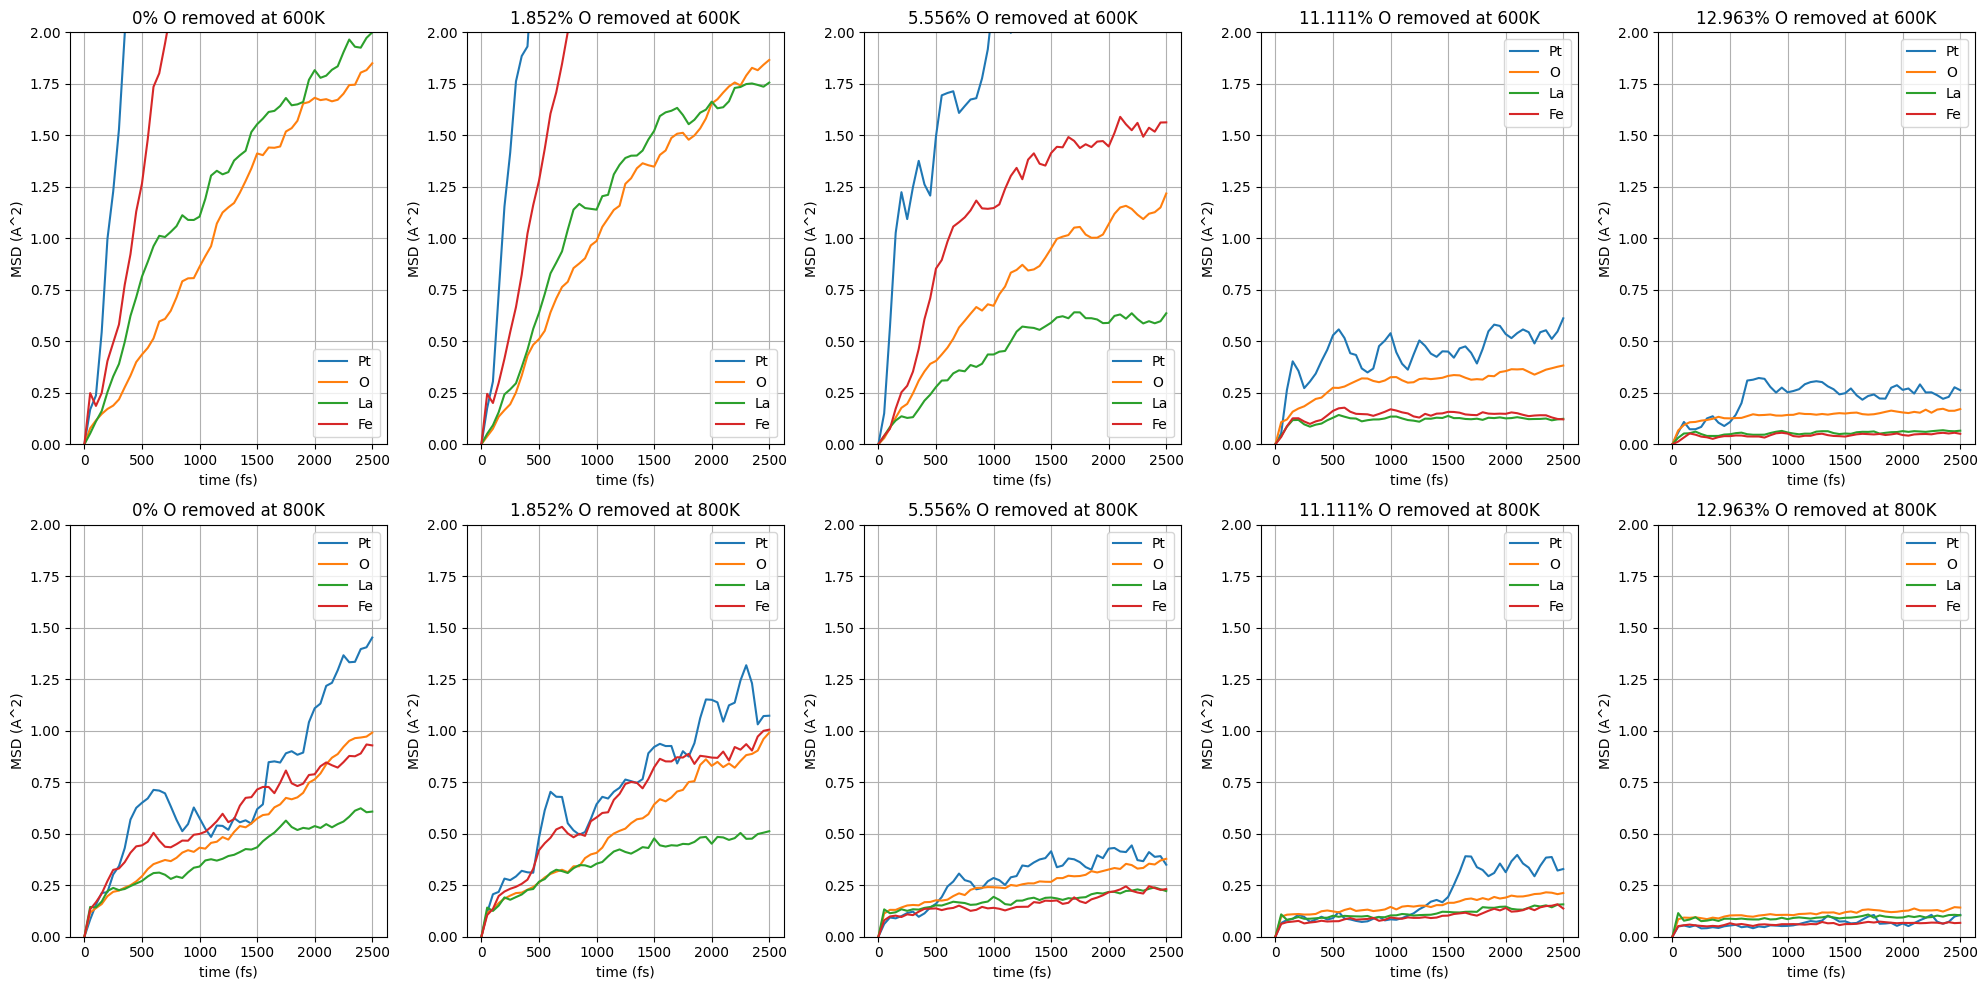

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import Trajectory

def get_positions(traj, element):
    element_indices = [i for i, x in enumerate(traj[0].get_chemical_symbols()) if x == element]
    positions_all = np.array([traj[i].get_positions() for i in range(len(traj))])
    positions = positions_all[:, element_indices]
    return positions

def calculate_msd(positions):
    msd = np.mean(np.sum((positions - positions[0]) ** 2, axis=2), axis=1)
    return msd

def plot_total_msd_subplot(ax, msd1, msd2, label1, label2, temp, percent_O_removed):
    time = np.arange(len(msd1)) * 50
    ax.plot(time, msd1, label=label1)
    ax.plot(time, msd2, label=label2)
    ax.grid(True)
    ax.set_xlabel("time (fs)")
    ax.set_ylabel("MSD (A^2)")
    ax.set_title(f"{percent_O_removed}% O removed at {temp}K")
    ax.legend()
    ax.set_ylim(0, 2)  # Set the same y-axis scale for all plots

temperatures = [600, 800]
percent_O_removed_list = ['0', '1.852', '5.556', '11.111', '12.963']

fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i, temp in enumerate(temperatures):
    for j, percent_O_removed in enumerate(percent_O_removed_list):
        traj = Trajectory(f"./output/structure_{j}_{temp}K_10ps.traj")

        positions_Pt = get_positions(traj, 'Pt')
        positions_O = get_positions(traj, 'O')
        positions_La = get_positions(traj, 'La')
        positions_Fe = get_positions(traj, 'Fe')

        msd_Pt = calculate_msd(positions_Pt)
        msd_O = calculate_msd(positions_O)
        msd_La = calculate_msd(positions_La)
        msd_Fe = calculate_msd(positions_Fe)

        plot_total_msd_subplot(axes[i, j], msd_Pt, msd_O, 'Pt', 'O', temp, percent_O_removed)
        plot_total_msd_subplot(axes[i, j], msd_La, msd_Fe, 'La', 'Fe', temp, percent_O_removed)

plt.tight_layout()
plt.show()


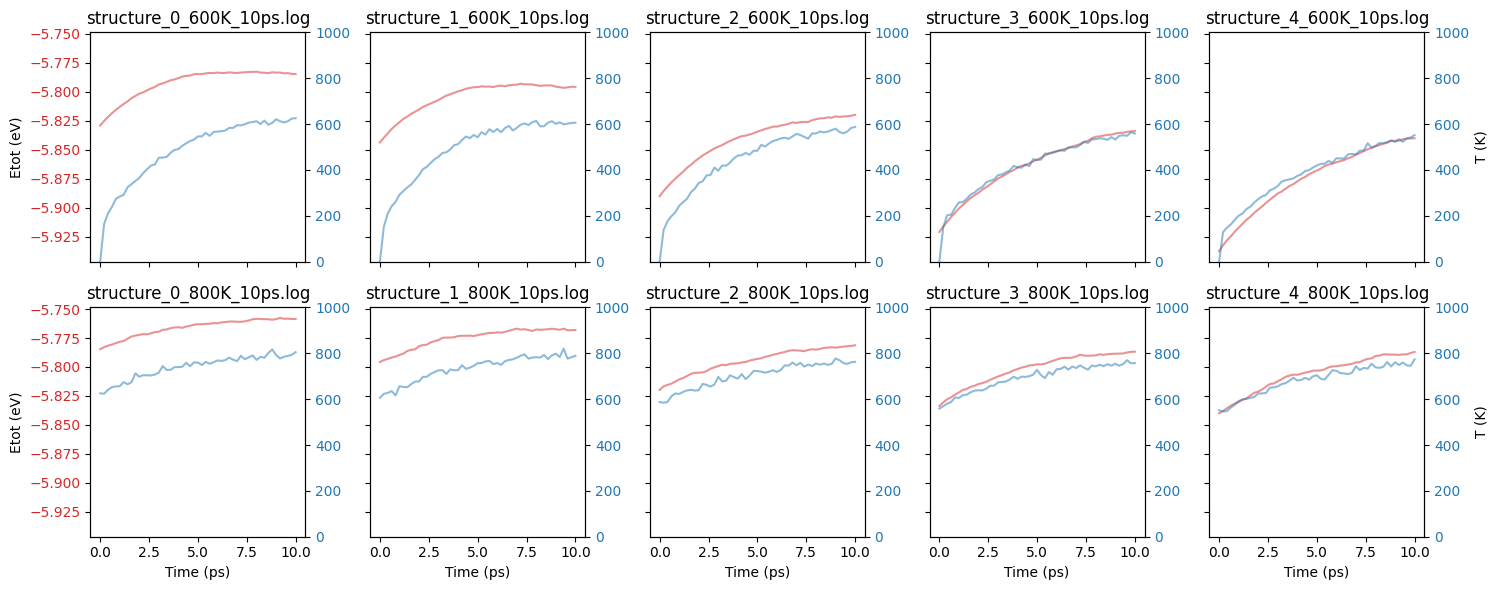

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def parse_log_file(filename):
    with open(filename, "r") as file:
        lines = file.readlines()

    runs = []
    run_data = []
    for line in lines:
        if "Time[ps]" in line:
            if run_data:
                runs.append(run_data)
                run_data = []
        else:
            try:
                tokens = line.split()
                time, etot, temp = float(tokens[0]), float(tokens[1]), float(tokens[4])
                run_data.append((time, etot, temp))
            except (ValueError, IndexError):
                pass

    runs.append(run_data)
    return runs

log_files_600K = [f"./output/structure_{i}_600K_10ps.log" for i in range(5)]
log_files_800K = [f"./output/structure_{i}_800K_10ps.log" for i in range(5)]

log_filenames = log_files_600K + log_files_800K

fig, axs = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)

for i, log_filename in enumerate(log_filenames):
    row = i // 5
    col = i % 5
    ax1 = axs[row, col]

    log_data = parse_log_file(log_filename)
    last_run_data = log_data[-1]

    time = [row[0] for row in last_run_data]
    etot = [row[1] for row in last_run_data]
    temp = [row[2] for row in last_run_data]

    ax1.plot(time, etot, color='tab:red', alpha=0.5)
    ax2 = ax1.twinx()
    ax2.plot(time, temp, color='tab:blue', alpha=0.5)
    
    ax2.set_ylim(0, 1000)

    ax1.set_title(log_filename.split('/')[-1])
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    if col == 0:
        ax1.set_ylabel('Etot (eV)')
    if row == 1:
        ax1.set_xlabel('Time (ps)')
    if col == 4:
        ax2.set_ylabel('T (K)')

fig.tight_layout()
plt.show()


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

21
Structure 1, Temperature 600K, Time 0 fs


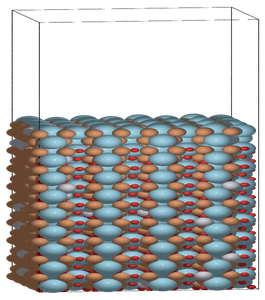

Structure 1, Temperature 600K, Time 500 fs


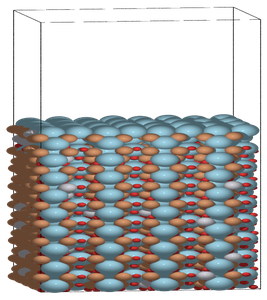

Structure 1, Temperature 600K, Time 1000 fs


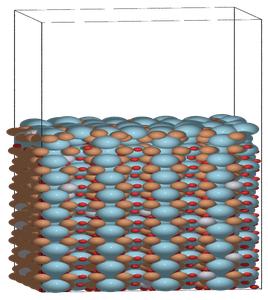

Structure 1, Temperature 600K, Time 1500 fs


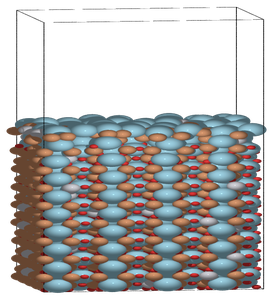

Structure 1, Temperature 600K, Time 2000 fs


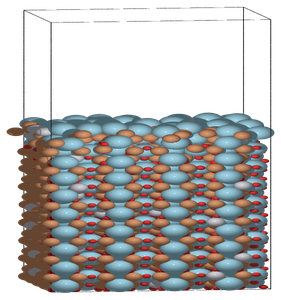

21
Structure 1, Temperature 800K, Time 0 fs


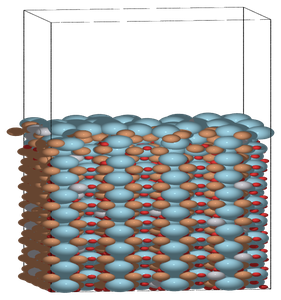

Structure 1, Temperature 800K, Time 500 fs


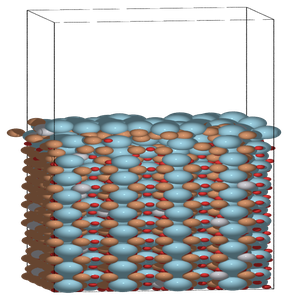

Structure 1, Temperature 800K, Time 1000 fs


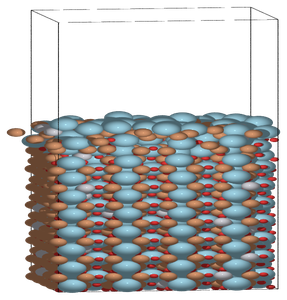

Structure 1, Temperature 800K, Time 1500 fs


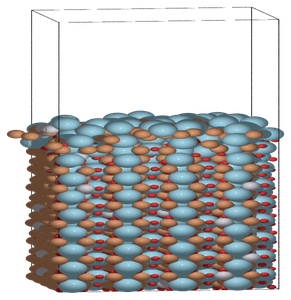

Structure 1, Temperature 800K, Time 2000 fs


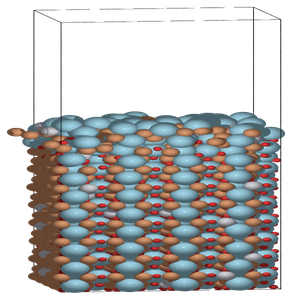

21
Structure 2, Temperature 600K, Time 0 fs


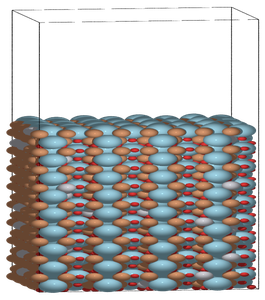

Structure 2, Temperature 600K, Time 500 fs


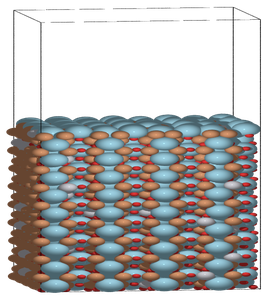

Structure 2, Temperature 600K, Time 1000 fs


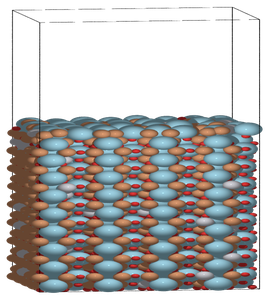

Structure 2, Temperature 600K, Time 1500 fs


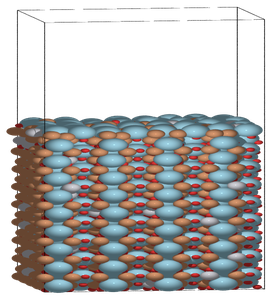

Structure 2, Temperature 600K, Time 2000 fs


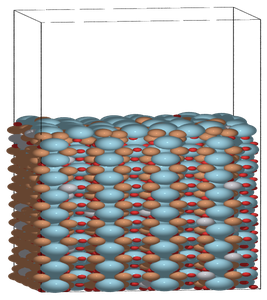

21
Structure 2, Temperature 800K, Time 0 fs


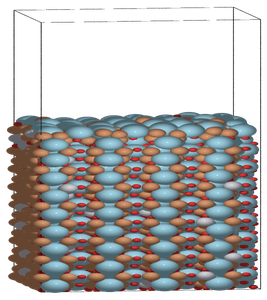

Structure 2, Temperature 800K, Time 500 fs


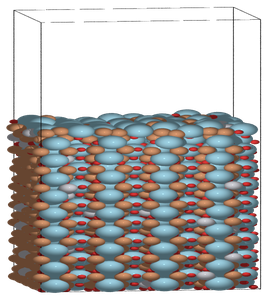

Structure 2, Temperature 800K, Time 1000 fs


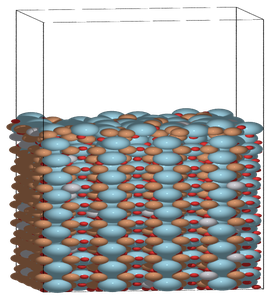

Structure 2, Temperature 800K, Time 1500 fs


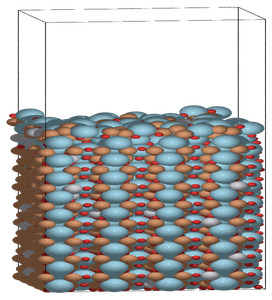

Structure 2, Temperature 800K, Time 2000 fs


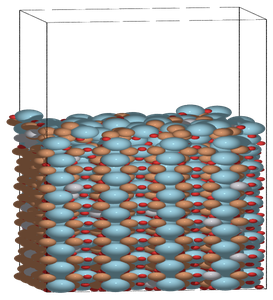

21
Structure 3, Temperature 600K, Time 0 fs


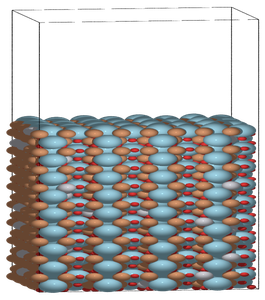

Structure 3, Temperature 600K, Time 500 fs


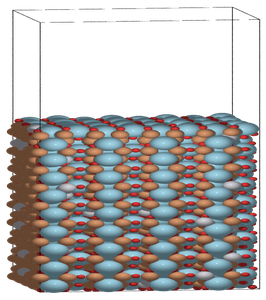

Structure 3, Temperature 600K, Time 1000 fs


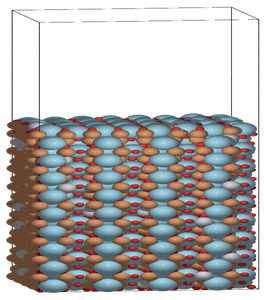

Structure 3, Temperature 600K, Time 1500 fs


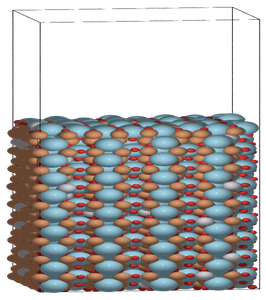

Structure 3, Temperature 600K, Time 2000 fs


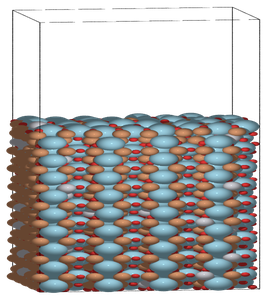

21
Structure 3, Temperature 800K, Time 0 fs


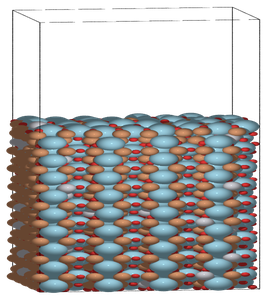

Structure 3, Temperature 800K, Time 500 fs


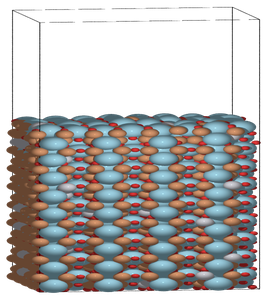

Structure 3, Temperature 800K, Time 1000 fs


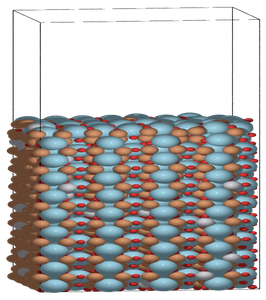

Structure 3, Temperature 800K, Time 1500 fs


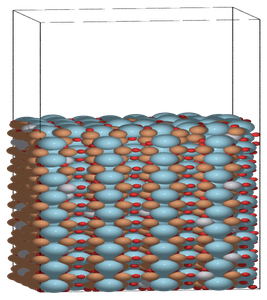

Structure 3, Temperature 800K, Time 2000 fs


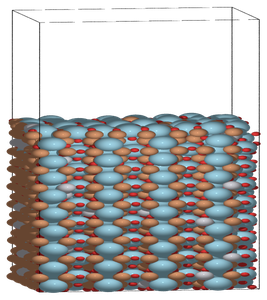

21
Structure 4, Temperature 600K, Time 0 fs


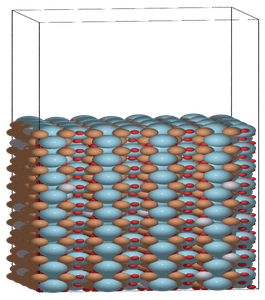

Structure 4, Temperature 600K, Time 500 fs


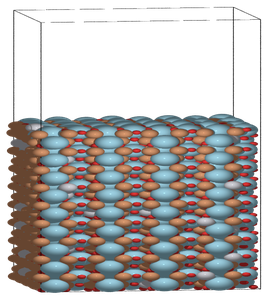

Structure 4, Temperature 600K, Time 1000 fs


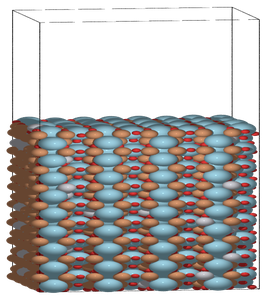

Structure 4, Temperature 600K, Time 1500 fs


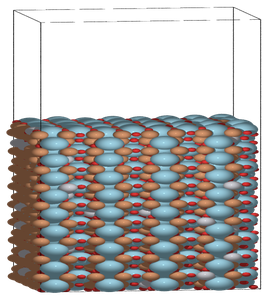

Structure 4, Temperature 600K, Time 2000 fs


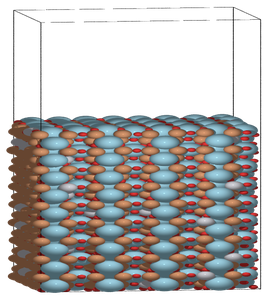

21
Structure 4, Temperature 800K, Time 0 fs


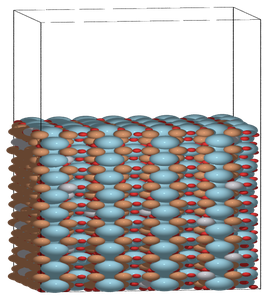

Structure 4, Temperature 800K, Time 500 fs


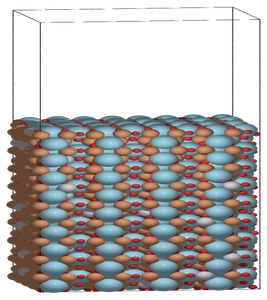

Structure 4, Temperature 800K, Time 1000 fs


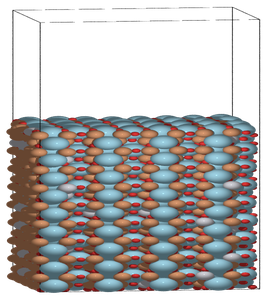

Structure 4, Temperature 800K, Time 1500 fs


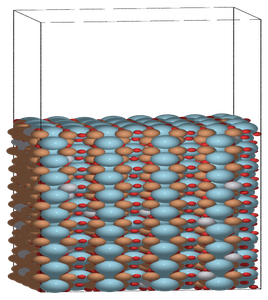

Structure 4, Temperature 800K, Time 2000 fs


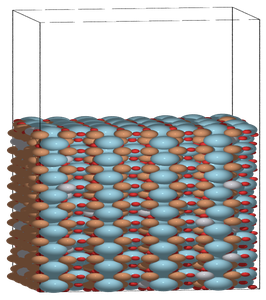

FileNotFoundError: [Errno 2] No such file or directory: 'output/structure_5_600K.traj'

In [16]:
from PIL import Image
from IPython.display import display as ipy_display

def render_and_display(nano, filename, max_size=(300, 300)):
    renderer = write(filename + '.pov', nano, rotation='10z,-80x')
    renderer.render()
    image_path = '/home/jovyan/1_Seokhyun/3_Exsolved_NP_Mgoon_YKim/' + filename + '.png'
    img = Image.open(image_path)
    img.thumbnail(max_size, Image.LANCZOS)
    ipy_display(img)

structures = range(1, 6)
temperatures = [600, 800]

for structure in structures:
    for temperature in temperatures:
        traj_file = f"./output/structure_{structure}_{temperature}K.traj"
        traj = Trajectory(traj_file)
        imd = len(traj)
        print(imd)
        
        for i in [0, int(imd/4), int(imd/2), int(imd*3/4), imd-1]:
            print(f"Structure {structure}, Temperature {temperature}K, Time {i*100} fs")
            filename = f"structure_{structure}_{temperature}K"
            render_and_display(traj[i], filename, (300, 300))
